In [1]:

import math
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

In [2]:
df_stocks = pd.read_csv('data/jpm_bars_2024-03-06.csv')

In [3]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)
df_stocks.head()

,open,high,low,close,volume,trade_count,vwap
date,,,,,,,
2016-01-04,63.95,64.060,63.01,63.62,27827227.0,145804.0,63.451452
2016-01-05,63.69,64.130,63.04,63.73,17591872.0,103027.0,63.519312
2016-01-06,62.70,63.125,62.34,62.81,24407202.0,124497.0,62.745693
2016-01-07,61.46,62.000,60.08,60.27,29310297.0,166584.0,60.834008
2016-01-08,61.13,61.270,58.85,58.92,24651311.0,135242.0,59.791316


In [4]:
df_stocks.tail(15)

,open,high,low,close,volume,trade_count,vwap
date,,,,,,,
2024-02-13,175.32,176.2299,172.615,174.26,8397631.0,119866.0,174.170059
2024-02-14,175.07,176.1000,174.420,176.03,7056664.0,92056.0,175.386226
2024-02-15,176.15,180.2100,176.150,179.87,8723390.0,120899.0,179.302307
2024-02-16,179.61,179.9800,178.160,179.03,8292848.0,99541.0,178.978772
2024-02-20,179.19,180.4600,178.405,179.73,9667959.0,103049.0,179.737550
2024-02-21,179.95,180.9900,178.520,180.90,7027857.0,96763.0,180.203631
2024-02-22,181.82,183.4200,181.240,183.07,9296459.0,111935.0,182.788280
2024-02-23,183.81,185.2000,183.190,183.99,7104018.0,108247.0,184.196089
2024-02-26,183.75,184.4600,182.480,183.36,7145391.0,98131.0,183.327353


In [5]:
df_lstm = df_stocks[['vwap', 'high', 'low', 'close']]

In [6]:
df_lstm.head()

,vwap,high,low,close
date,,,,
2016-01-04,63.451452,64.060,63.01,63.62
2016-01-05,63.519312,64.130,63.04,63.73
2016-01-06,62.745693,63.125,62.34,62.81
2016-01-07,60.834008,62.000,60.08,60.27
2016-01-08,59.791316,61.270,58.85,58.92


In [7]:
df_lstm.head()

,vwap,high,low,close
date,,,,
2016-01-04,63.451452,64.060,63.01,63.62
2016-01-05,63.519312,64.130,63.04,63.73
2016-01-06,62.745693,63.125,62.34,62.81
2016-01-07,60.834008,62.000,60.08,60.27
2016-01-08,59.791316,61.270,58.85,58.92


In [8]:
df_lstm.shape

(2056, 4)

In [9]:
# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(df_lstm) + 1, 1)

In [10]:
# TAKING DIFFERENT INDICATORS FOR PREDICTION
HLC_avg = df_lstm[['high', 'low', 'close']].mean(axis=1)
VWAP_avg = df_lstm[['vwap']]
close_val = df_lstm[['close']]

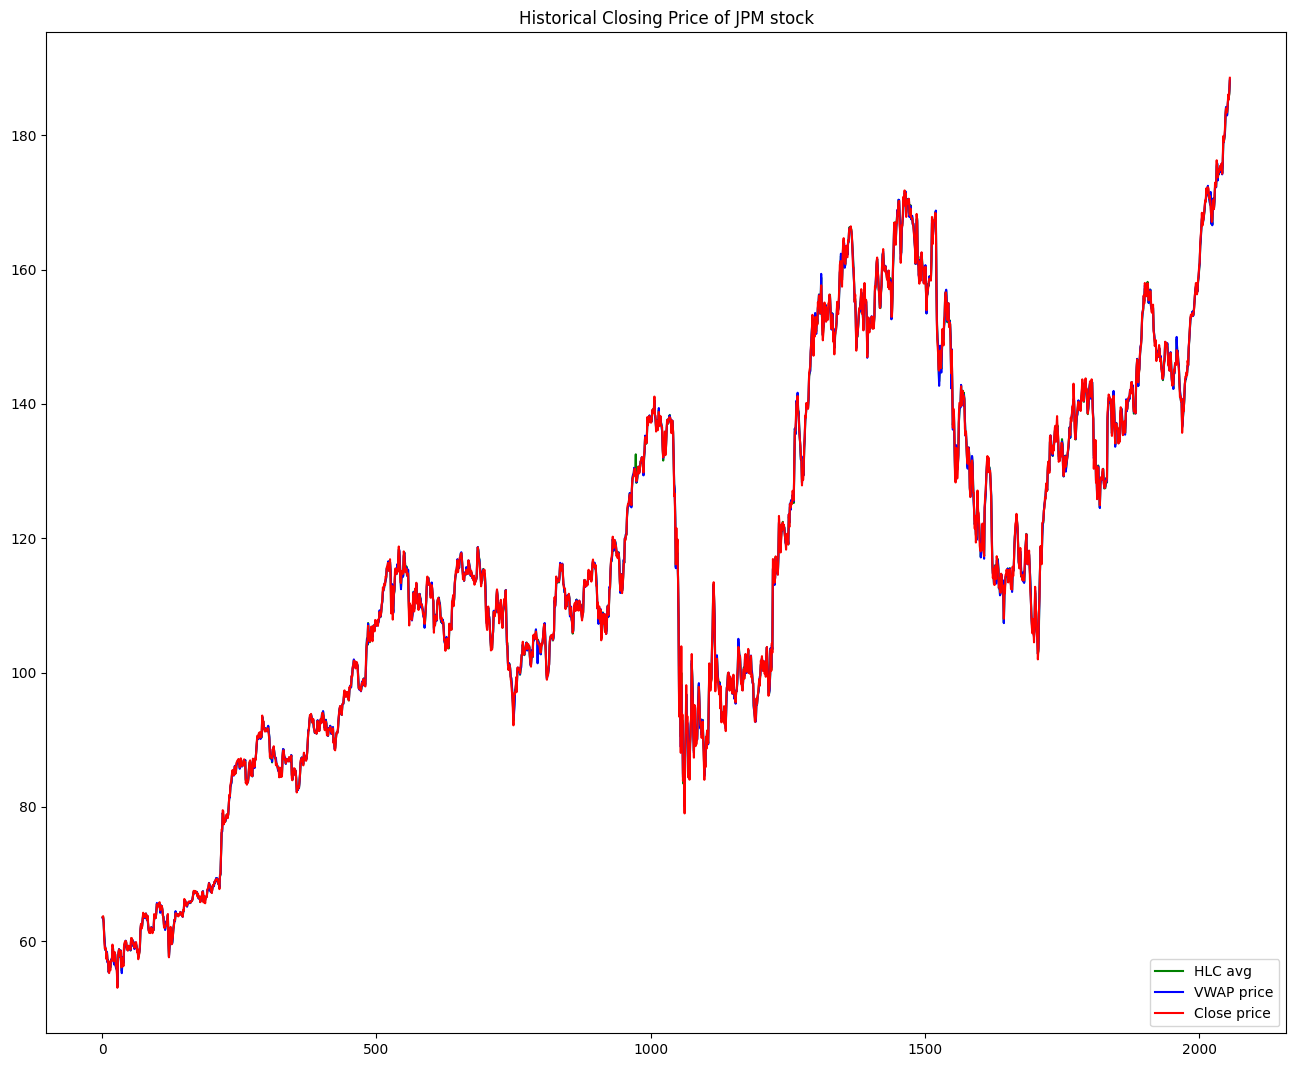

In [11]:
plt.figure(figsize=(16, 13))
plt.plot(obs, HLC_avg, 'g', label='HLC avg')
plt.plot(obs, VWAP_avg, 'b', label='VWAP price')
plt.plot(obs, close_val, 'r', label='Close price')
plt.title('Historical Closing Price of JPM stock')
plt.legend(loc='lower right')
plt.show()

In [12]:
# RESHAPING OF THE DATASET UTIL
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - step_size - 1):
        a = dataset[i:(i + step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

In [13]:
# PREPARATION OF TIME SERIES DATASET
VWAP_avg = np.reshape(VWAP_avg.values, (len(VWAP_avg), 1))  # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
VWAP_avg = scaler.fit_transform(VWAP_avg)

In [14]:
# TRAIN-TEST SPLIT
train_VWAP = int(len(VWAP_avg) * 0.75)
test_VWAP = len(VWAP_avg) - train_VWAP
train_VWAP, test_VWAP = VWAP_avg[0:train_VWAP, :], VWAP_avg[train_VWAP:len(VWAP_avg), :]

In [15]:
# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_VWAP, 1)
testX, testY = new_dataset(test_VWAP, 1)

In [16]:
# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

In [17]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [18]:
# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["accuracy"])  # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2, validation_data=(testX, testY))

Epoch 1/5
1540/1540 - 3s - 2ms/step - accuracy: 6.4935e-04 - loss: 0.0103 - val_accuracy: 0.0000e+00 - val_loss: 4.0467e-04
Epoch 2/5
1540/1540 - 2s - 1ms/step - accuracy: 6.4935e-04 - loss: 3.3200e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.0694e-04
Epoch 3/5
1540/1540 - 2s - 1ms/step - accuracy: 6.4935e-04 - loss: 2.3583e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.9503e-04
Epoch 4/5
1540/1540 - 1s - 930us/step - accuracy: 6.4935e-04 - loss: 2.4671e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.9285e-04
Epoch 5/5
1540/1540 - 1s - 930us/step - accuracy: 6.4935e-04 - loss: 2.3335e-04 - val_accuracy: 0.0000e+00 - val_loss: 2.2815e-04


In [19]:
# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


In [20]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [21]:
# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train RMSE: %.2f' % (trainScore))

Train RMSE: 1.78


In [22]:
# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test RMSE: %.2f' % (testScore))

Test RMSE: 2.04


In [23]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(VWAP_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict) + step_size, :] = trainPredict

In [24]:
# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(VWAP_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (step_size * 2) + 1:len(VWAP_avg) - 1, :] = testPredict

In [25]:
# DE-NORMALIZING MAIN DATASET 
VWAP_avg = scaler.inverse_transform(VWAP_avg)

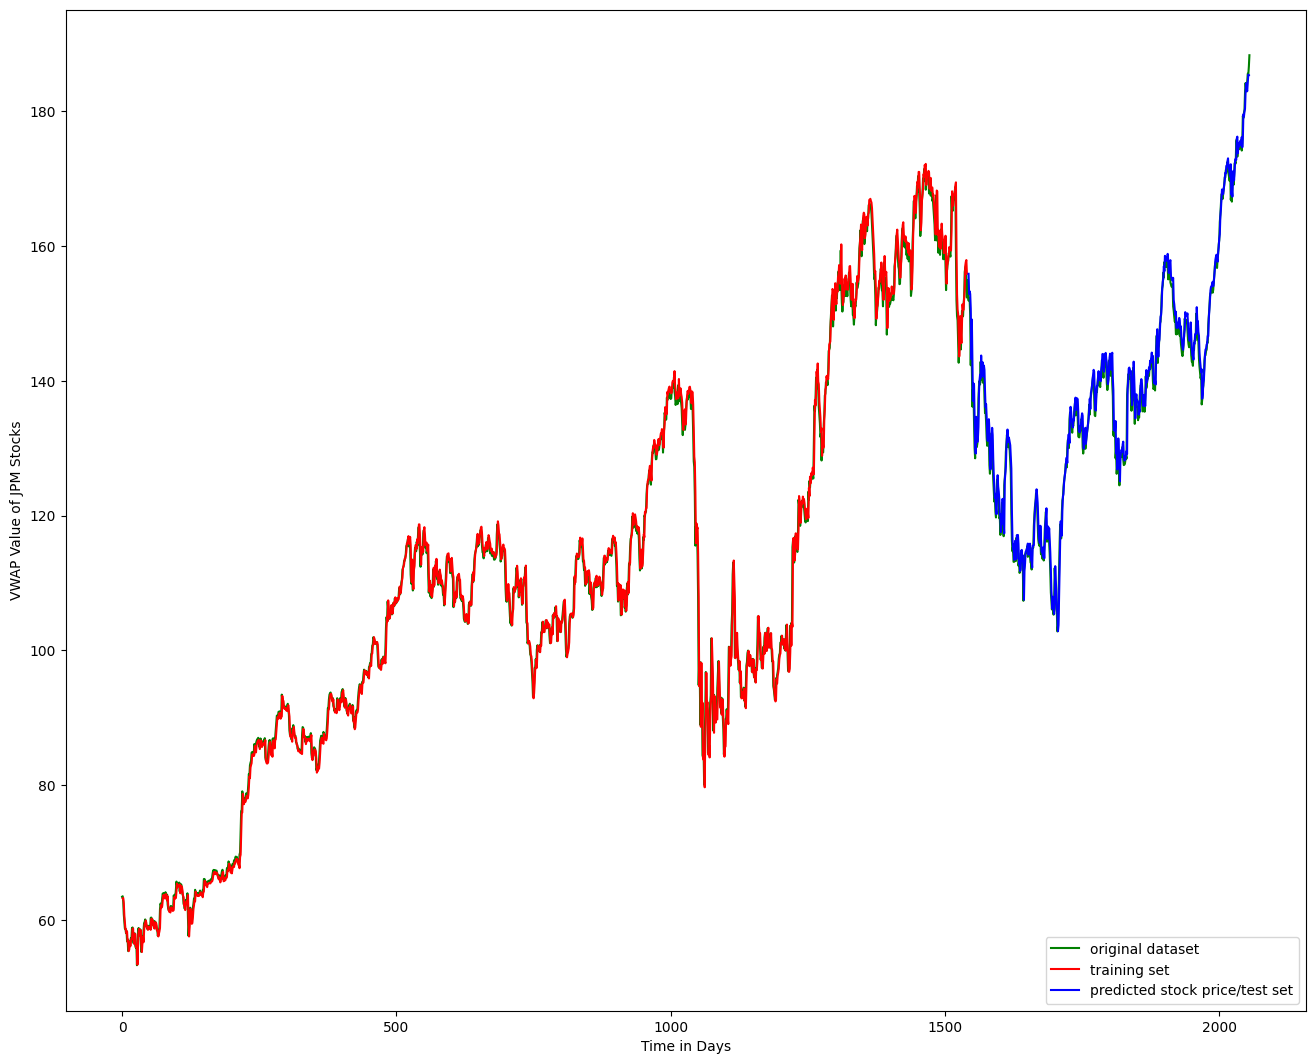

In [26]:
# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS
plt.figure(figsize=(16, 13))
plt.plot(VWAP_avg, 'g', label='original dataset')
plt.plot(trainPredictPlot, 'r', label='training set')
plt.plot(testPredictPlot, 'b', label='predicted stock price/test set')
plt.legend(loc='lower right')
plt.xlabel('Time in Days')
plt.ylabel('VWAP Value of JPM Stocks')
plt.show()

In [27]:
# PREDICT FUTURE VALUES
last_val = testPredict[-1]
last_val_scaled = last_val / last_val
next_val = model.predict(np.reshape(last_val_scaled, (1, 1, 1)))
print("Last Day Value:", np.ndarray.item(last_val))
print("Next Day Value:", np.ndarray.item(last_val * next_val))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Last Day Value: 185.36231994628906
Next Day Value: 184.91940307617188
